In [105]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [80]:
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# Data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# Metadata
# print(cdc_diabetes_health_indicators.metadata)

# Variable information
# print(cdc_diabetes_health_indicators.variables)

In [81]:
means = X.mean()
X = X.fillna(means)  # Apply the means to fill NaNs without using inplace=True

# Convert categorical variables using one-hot encoding if necessary
X = pd.get_dummies(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [82]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Split the combined validation/test set into validation and test sets (50% each of test+validation set)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).view(-1, 1)
X_val_tensor = torch.tensor(X_val.astype(np.float32))
y_val_tensor = torch.tensor(y_val.values.astype(np.float32)).view(-1, 1)
X_test_tensor = torch.tensor(X_test.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)

# Create DataLoaders for training and validation sets
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [83]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using mps device


In [84]:
class DiabetesPredictor(nn.Module):
    def __init__(self, input_features):
        super(DiabetesPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.network(x)

In [85]:
input_features = X_train.shape[1]
model = DiabetesPredictor(input_features).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [86]:
num_epochs = 40

train_losses = []  
val_losses = []    

for epoch in range(num_epochs):
    model.train()
    train_loss_accum = []  # List to store losses of each batch

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)  # Ensure data is on the correct device
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_accum.append(loss.item())  # Append the loss of the current batch

    model.eval()
    validation_losses = []  # List to store validation losses
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)  # Ensure data is on the correct device
            outputs = model(data)
            val_loss = criterion(outputs, labels)
            validation_losses.append(val_loss.item())
        
        avg_train_loss = np.mean(train_loss_accum)
        avg_val_loss = np.mean(validation_losses)
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

# Now, train_losses and val_losses contain the average losses per epoch for training and validation, respectively.

Epoch 1, Train Loss: 0.3424, Validation Loss: 0.3248
Epoch 2, Train Loss: 0.3184, Validation Loss: 0.3218
Epoch 3, Train Loss: 0.3173, Validation Loss: 0.3255
Epoch 4, Train Loss: 0.3162, Validation Loss: 0.3183
Epoch 5, Train Loss: 0.3161, Validation Loss: 0.3212
Epoch 6, Train Loss: 0.3155, Validation Loss: 0.3179
Epoch 7, Train Loss: 0.3149, Validation Loss: 0.3211
Epoch 8, Train Loss: 0.3150, Validation Loss: 0.3198
Epoch 9, Train Loss: 0.3144, Validation Loss: 0.3224
Epoch 10, Train Loss: 0.3141, Validation Loss: 0.3250
Epoch 11, Train Loss: 0.3132, Validation Loss: 0.3177
Epoch 12, Train Loss: 0.3135, Validation Loss: 0.3175
Epoch 13, Train Loss: 0.3131, Validation Loss: 0.3216
Epoch 14, Train Loss: 0.3129, Validation Loss: 0.3235
Epoch 15, Train Loss: 0.3126, Validation Loss: 0.3206
Epoch 16, Train Loss: 0.3121, Validation Loss: 0.3203
Epoch 17, Train Loss: 0.3117, Validation Loss: 0.3190
Epoch 18, Train Loss: 0.3114, Validation Loss: 0.3189
Epoch 19, Train Loss: 0.3110, Validat

In [87]:
model_path = './pytorch_diabetes_model.pth'  # Define the path where you want to save the model
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ./pytorch_diabetes_model.pth


In [104]:
y_pred = []
y_true = []

# Variable to store test loss
test_losses = []

# Disable gradient computation since we are only making predictions
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())
        
        # Convert outputs to predicted class (0 or 1)
        predicted_probs = torch.sigmoid(outputs)
        predicted_labels = (predicted_probs > 0.54).int()
        
        # Store predictions and actual labels
        y_pred.extend(predicted_labels.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate overall test loss
overall_test_loss = np.mean(test_losses)
print(f'Overall Test Loss: {overall_test_loss}')

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Overall Test Loss: 0.3173334111669776
Test Accuracy: 0.7735
Confusion Matrix:
[[34432  9357]
 [ 2137  4810]]


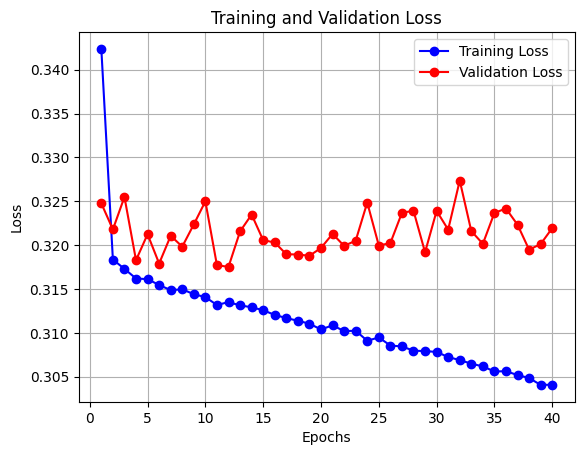

In [108]:
epochs = range(1, len(train_losses) + 1)

plt.figure()
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('pytorch_diabetes_train_val_loss.svg', format='svg')
plt.show()

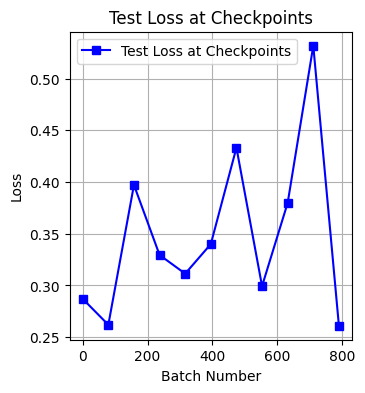

In [112]:
checkpoints = range(0, len(test_losses), max(1, len(test_losses) // 10))  # Adjust divisor for fewer points if needed
selected_test_losses = [test_losses[i] for i in checkpoints]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(checkpoints, selected_test_losses, 'bs-', label='Test Loss at Checkpoints')
plt.title('Test Loss at Checkpoints')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('pytorch_diabetes_test_loss.svg', format='svg')
plt.show()